# Beta Bank Churn Prediction 

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.
Our task is to build a model with the maximum possible F1 score. To pass the project, we need an F1 score of at least 0.59, when checked for a test set.
Additionally, we will measure the AUC-ROC metric and compare it with the F1.

**Project Goal**: Build a model to predict whether a customer will leave the bank soon, based on data on clients’ past behavior and termination of contracts with the bank, with the maximum possible F1 score (at least 0.59, when checked for a test set). Additionally, AUC-ROC metric should be measured and compared with the F1.

## Loading and preparing data

In [1]:
# Loading libraries
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
# pd.options.display.float_format = '{:.3f}'.format

In [2]:
# load the data into a DataFrame: 
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
# looking at a sample of the data:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# General info of the data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# checking for explicit duplicates: 
df.duplicated().sum()

0

We have 10k entries and 14 columns, only one ('Tenure') with about 9% missing values. No explicit duplicates. Data includes:

Features:
- RowNumber — data string index
- CustomerId — unique customer identifier
- Surname — surname
- CreditScore — credit score
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — period of maturation for a customer’s fixed deposit (years)
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary

Target:
- Exited — сustomer has left

**Preparing Data**: Following inspection of the data, we will perform the following steps

1. Droping the data with missing values on 'Tenure', since it will keep ~91% of the data and it will be complete.
2. Droping the 'RowNumber', 'CustomerId' and 'Surname' columns since they have no real relevance to predicting churn and we dont want them to confuse the model.
3. OHE encoding to the other categorical columns ('Geography' and 'Gender').
4. Splitting the data randomly into 3 sets: training, validation, test (60:20:20).
5. Standardize the numeric features.

In [6]:
# Droping the data with the missing values on 'Tenure': 
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
RowNumber          9091 non-null int64
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


Ok, all 14 columns have full 9091 entries, no missing values.

In [7]:
# Droping the first 3 columns:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.shape

(9091, 11)

Ok, 11 relevant columns remain.

In [8]:
# OHE encoding:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
CreditScore          9091 non-null int64
Age                  9091 non-null int64
Tenure               9091 non-null float64
Balance              9091 non-null float64
NumOfProducts        9091 non-null int64
HasCrCard            9091 non-null int64
IsActiveMember       9091 non-null int64
EstimatedSalary      9091 non-null float64
Exited               9091 non-null int64
Geography_Germany    9091 non-null uint8
Geography_Spain      9091 non-null uint8
Gender_Male          9091 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


Ok, after OHE encoding (avoiding dummies traps - droping first) we have 12 columns altogether. 

In [9]:
# Splitting the data randomly into 3 sets: training, validation, test (60:20:20), and checking their sizes: 
from sklearn.model_selection import train_test_split

# We want to split the data in 60:20:20 for train:valid:test dataset
train_size=0.6

# For convenience we will symbol 'features' as 'X', and 'target' as 'y'
X = df_ohe.drop(['Exited'], axis=1)
y = df_ohe['Exited']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6, random_state=12345, stratify=y)

# Now since we want the valid and test size to be equal (20% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=12345, stratify=y_rem)

print('Training features shape:', X_train.shape), print('Training target shape:', y_train.shape)
print('Validation features shape:', X_valid.shape), print('Validation target shape:', y_valid.shape)
print('Test features shape:', X_test.shape), print('Test target shape:', y_test.shape)

Training features shape: (5454, 11)
Training target shape: (5454,)
Validation features shape: (1818, 11)
Validation target shape: (1818,)
Test features shape: (1819, 11)
Test target shape: (1819,)


(None, None)

Ok, the 9091 entries are randomly divided into 3 sets, in ratio 60:20:20 for train:valid:test datasets. 

In [10]:
# Standardize the numeric features:
from sklearn.preprocessing import StandardScaler

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'EstimatedSalary']
# Create an instance of the StandardScaler() class and tune it using the training data.
scaler = StandardScaler()
scaler.fit(X_train[numeric])

# Transform train, validation and test data: 
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
#pd.options.mode.chained_assignment = None
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9723,-1.292898,-0.660843,0.686341,0.786636,-0.910943,0,0,-0.223548,0,0,1
1224,-1.563714,0.778434,1.034232,0.833795,-0.910943,1,0,1.383021,0,1,0
8377,1.581914,0.106771,-0.357331,-1.222967,0.789359,1,1,-0.308331,0,1,1
8014,0.842379,0.010820,-1.053112,0.807063,-0.910943,1,1,-0.430980,0,1,0
2491,-0.397123,-1.236554,-0.357331,-1.222967,0.789359,1,1,1.392642,0,1,0


Now all relevant numeric features are standardized. 

## Investigating the balance of classes

0    0.796062
1    0.203938
Name: Exited, dtype: float64


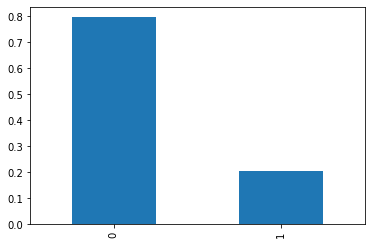

In [11]:
# Check target class frequencies:
class_frequency = y.value_counts(normalize=True) 
print(class_frequency)
class_frequency.plot(kind='bar')
plt.show()

The positive answers (exited) are about a fifth (!) of all the customers. The classes are imbalanced 4:1 (negative:positive), while the critical thing for our bank is not to miss optional leavers (positive).   

## Train a model without taking into account the imbalance

First we will investigate training a model without taking into account the imbalance. We will try first with Random Forest Classifier, first with 20 trees.

In [12]:
# Random Forest with 20 trees: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define the model
model = RandomForestClassifier(random_state=12345, n_estimators=20) 

# Train the model on the training set:
model.fit(X_train, y_train)

# Investigate model f1_score for validation set: 
predicted_valid = model.predict(X_valid)
print(f1_score(y_valid, predicted_valid))

0.5911330049261084


We got F1 of 0.5911 on the validation set (which is already above our treshold, first time any model is using any part of the data). Let's see if 100 trees will improve the F1: 

In [13]:
# Random Forest with 100 trees: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define the model
model = RandomForestClassifier(random_state=12345, n_estimators=100) 

# Train the model on the training set:
model.fit(X_train, y_train)

# Investigate model f1_score for validation set: 
predicted_valid = model.predict(X_valid)
print(f1_score(y_valid, predicted_valid))

0.5957446808510638


F1 on validation set is a bit better (0.5957). Before we move to improve the balance to try and improve our model quality - we will also calculate the AUC-ROC score before improving balance.

In [14]:
# Measuring AUC-ROC metric on the validation set: 
from sklearn.metrics import roc_auc_score
model = RandomForestClassifier(n_estimators=100, random_state=12345)
model.fit(X_train, y_train)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(y_test, probabilities_one_test)

print(auc_roc)

0.8371803845065598


## Improving model quality

First we will try to fix the imbalance by using class weight adjustment and upsampling, then we will try to tue some hyperparameters (tree depth and number of trees). We will start with 20 trees, and only later tune the number of trees. All improvements will be trined on the training set and F1 investigated on the validation set.  

### Fixing class imbalance 

#### Class Weight Adjustment

In [16]:
# Random Forest with 20 trees with class_weight='balanced': 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define the model
model = RandomForestClassifier(random_state=12345, n_estimators=20, class_weight='balanced') 

# Train the model on the training set:
model.fit(X_train, y_train)

# Investigate model f1_score for validation set: 
predicted_valid = model.predict(X_valid)
print(f1_score(y_valid, predicted_valid))

0.543859649122807


No improvement, F1 went down from 0.5911 (20 trees) to 0.544. We will continue to upsampling, giving the positive (exited) more power (X4 - following the 4:1 ratio between the classes), in order to minimize the risk of missing them.  

#### Upsampling

In [28]:
# Random Forest with 20 trees with upsampling: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    X_train, y_train, 4
)

# Define the model
model = RandomForestClassifier(random_state=12345, n_estimators=20) 

# Train the model on the training set:
model.fit(features_upsampled, target_upsampled)

# Investigate model f1_score for validation set: 
predicted_valid = model.predict(X_valid)
print(f1_score(y_valid, predicted_valid))

0.59882005899705


Ok, for 20 trees this is our best F1 (0.5988) on the validation set so far. We will move to tuning hyperparameters.

### Tuning Hyperparameters 

First we will try - still with 20 trees - to choose optimal max_tree_depth: we will go through depths from 1 to 16 and check F1. 

In [29]:
# Try to choose optimal tree depth with random forest of 20 trees

for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(X_valid)
    print(depth, f1_score(y_valid, predicted_valid))

1 0.5433746425166825
2 0.5515210991167812
3 0.5737704918032787
4 0.6025641025641026
5 0.6081229418221735
6 0.6072607260726073
7 0.6228070175438596
8 0.6341463414634148
9 0.617169373549884
10 0.6223277909738717
11 0.6287128712871287
12 0.646074646074646
13 0.6216216216216216
14 0.6198347107438017
15 0.6253521126760563


Best one is depth of 12, F1=0.646 (improved from 0.5988). Let's check if here - maybe the combined impact of upsamling and class weight adjustment (that alone was not effective) might yield better F1:

In [30]:
# Try to choose optimal tree depth with random forest of 20 trees, adding class_weight='balanced':  

for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(X_valid)
    print(depth, f1_score(y_valid, predicted_valid))

1 0.5433746425166825
2 0.5614385614385615
3 0.5797705943691346
4 0.5900216919739697
5 0.6122448979591836
6 0.6105499438832772
7 0.6119733924611973
8 0.6326767091541136
9 0.6301050175029173
10 0.6159420289855073
11 0.6218905472636815
12 0.6287978863936592
13 0.631439894319683
14 0.6145404663923182
15 0.6073871409028728


No, no improvement. we will keep only the upsampling. balance improvemment methods. We will choose max tree depth of 12 (we got F1 of 0.646 - the highest so far for 20 trees). Let's see if 100 trees improve the F1: 

In [33]:
# Check if 100 trees (with the optimal tree depth) improves f1_score:

model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(X_valid)
print(f1_score(y_valid, predicted_valid))


0.6394736842105263


F1 has changed from 0.646 to 0.639 - a small decrease. Maybe the optimal max tree depth is different for 100 trees (than the 12 trees that were best for 20 trees), let's investigate: 

In [34]:
# Try to choose optimal tree depth with random forest of 100 trees:  

for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(X_valid)
    print(depth, f1_score(y_valid, predicted_valid))

1 0.5402650356778798
2 0.5426052889324192
3 0.5792235047219307
4 0.5978494623655913
5 0.6034858387799563
6 0.6184649610678532
7 0.6298342541436462
8 0.6285714285714286
9 0.628175519630485
10 0.6257378984651712
11 0.631578947368421
12 0.6394736842105263
13 0.63257065948856
14 0.6395511921458626
15 0.6246498599439777


Not realy, here tree depth of 12 and 14 are best, but the highest F1 is only 0.63955 (on the validation set), which is lower than the 0.646 we got for 20 trees. Let's return to our best model so far:   

In [40]:
# The chosen model - RandomForestClassifier model of 20 trees and max tree depth of 12:
model = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(X_valid)
print(f1_score(y_valid, predicted_valid))

0.646074646074646


We are almost ready to check our model F1 on the test set, and our last developmant step will be to train the model (with our tuned hyperparameters) once more - this time on the concatenated train+validation set (just before evaluating the model on the test set), so as not to waste the validation set data. Of course, we will apply upsampling to the concatenated train+validation set too.

In [41]:
# Training the final model on the concatenated train+validation set, after upsampling it:

# Concatenating train and valid:
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])

# Applying upsampling to the concatenated set:
features_upsampled, target_upsampled = upsample(
    X_train_valid, y_train_valid, 4
)

# Define the model and train it on the concatenated set:
model = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

## Test the chosen model on the test set 

### F1 Score

Now for the first time we will use the test set, to test our model's F1.

In [42]:
# test the chosen RandomForestClassifier model of 20 trees and max tree depth of 12 on the test set: 
model = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(X_test)
print(f1_score(y_test, predicted_test))

0.6002587322121604


Ok, our F1 is 0.60, checked on the test set, and it is above our desired threshold. This is our final model. As requested - we will also measure the AUC-ROC and plot the ROC curve. 

### AUC-ROC 

In [43]:
# Measuring AUC-ROC metric on the test set: 
from sklearn.metrics import roc_auc_score
model = RandomForestClassifier(n_estimators=20, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(y_test, probabilities_one_test)

print(auc_roc)

0.845752483209483


Slight improvement in this measure from before the imbalance fixing (0.837) to our final model (0.846). 

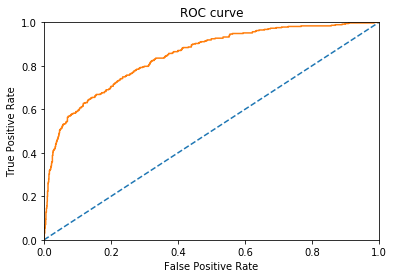

In [44]:
# Plotting the ROC curve:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()

# < plot the graph >

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >

# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >

# < add the heading "ROC curve" with the function plt.title() >

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

This ROC curve shows how - when tuning classification threshold - it is possible to raise the TPR (measuring how much of all positives - clients at churn risk - we will actually predict), at the expense of raising also the FPR (measuring how much of all the non-churn risk clients we will wrongly suspect for churn). This will allow to clarify with management the priorities (not missing any churn-risk custoemr vs. how much effort to waste by mistake on customers that are not really churn-risk) and maybe adjust classification threshold.    

## Genral conclusion

1. **Project Goal**: Build a model to predict whether a customer will leave the bank soon, based on data on clients’ past behavior and termination of contracts with the bank, with the maximum possible F1 score (at least 0.59, when checked for a test set). Additionally, AUC-ROC metric should be measured and compared with the F1. 


2. **Data and it's Preparation**: Original data includes 10k entries and 14 columns, only one ('Tenure') with about 9% missing values. No explicit duplicatesData includes:

Features:
- RowNumber — data string index
- CustomerId — unique customer identifier
- Surname — surname
- CreditScore — credit score
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — period of maturation for a customer’s fixed deposit (years)
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary

Target:
- Exited — сustomer has left

**Preparing Data**: Following inspection of the data, we performed the following steps

    1. Droping the data with missing values on 'Tenure', since it will keep ~91% of the data and it will be complete.
    2. Droping the 'RowNumber', 'CustomerId' and 'Surname' columns since they have no real relevance to predicting churn and we dont want them to confuse the model.
    3. OHE encoding to the other categorical columns ('Geography' and 'Gender').
    4. Splitting the data randomly into 3 sets: training, validation, test (60:20:20).
    5. Standardize the numeric features.

3. **Class Balance and initial model**: The positive answers (exited) are about a fifth (!) of all the customers. The classes are imbalanced 4:1. Model was trained without taking into account the imbalance. Random forest classifier model produced initial F1 on the validation set (20 trees: F1=0.5911, 100 trees: F1=0.5957). AUC-ROC for test set was 0.837.   

4. **Fixing Imbalance**: 2 methods for fixing imbalance were used: class weight adjustment and upsampling. The second one ( together with the first) improved F1 with 20 trees to 0.5988 on the validation set.

5. **Model Improvement - tuning hyperparameters**: first, max tree depth was optimized (checked on 20 trees) and depth of 12 was chosen (with 20 trees, on validation set, F1=0.646). Then, it was investigated wether 100 trees will provide a better F1. It did not, and our chosen model is RandomForestClassifier with 20 trees and max tree depth of 12. 

6. **Additional model training**: Training the final model on the concatenated train+validation set, after upsampling it. 

6. **Model Testing**: The chosen model was tested on the test set. F1 is 0.60, above the desired threshold. AUC-ROC = 0.846, slight improvement over the 0.837 before the balance and tuning. The ROC curve (above) shows how - when tuning classification threshold - it is possible to raise the TPR (measuring how much of all positives = clietnts at churn risk we will actually predict), at the expense of raising also the FPR (measuring how much of all the non-churn risk clients we will wrongly suspect for churn). This will allow to clarify with management the priorities (not missing any churn-risk custoemr vs. not wasting effort by mistake on customers that are not churn-risk) and maybe adjust classification threshold.    

7. **Overall Conclusion**: A model was developed to predict churn, with F1 of 0.60 checked on a test set. Project goal was achieved. Using the ROC curve it is possible to tune the model (tune classification threshold) according to management priorities.  